In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib as mpl
import seaborn as sns

%matplotlib inline
sns.set()


""" 
DSC672
Team: John Matune, Mike Yacobucci, Steve Rummel
Project: Energy Consumption and Renewable Energy
Purpose: 

Import power consumption data from the relevant source files, 
convert string-format date and time into valid datetime values,
remove unneeded columns, normalize column headers, and
export to canonical data source for further analysis.
"""

consumption_files = ['powercity_consumption.csv',
                     'calendar_days_consumption.csv',
                     'car_charging.csv'
                     ]

for file in consumption_files:
    consumption = pd.read_csv('./raw/{}'.format(file))
    print(file)
    print(consumption.head())
    print(consumption.dtypes)
    for field in list(consumption):
        print("--------------------")
        print(field)
        print(consumption[field].describe())
        print("--------------------")
    print("********************")



powercity_consumption.csv
          Year  Month  Day  Hour        Sector  Electricity_KW_SQFT
0  Consumption      1    1     1  FOOD_SERVICE             0.005416
1  Consumption      1    1     1       GROCERY             0.002030
2  Consumption      1    1     1   HEALTH_CARE             0.002390
3  Consumption      1    1     1   K12_SCHOOLS             0.000818
4  Consumption      1    1     1       LODGING             0.001209
Year                    object
Month                    int64
Day                      int64
Hour                     int64
Sector                  object
Electricity_KW_SQFT    float64
dtype: object
--------------------
Year
count           70080
unique              1
top       Consumption
freq            70080
Name: Year, dtype: object
--------------------
--------------------
Month
count    70080.000000
mean         6.526027
std          3.447876
min          1.000000
25%          4.000000
50%          7.000000
75%         10.000000
max         12.000000
Na

In [2]:
# Process calendar_days_consumption.csv

calendar = pd.read_csv('./raw/calendar_days_consumption.csv')

for field in list(calendar):
    calendar[field].fillna('FALSE', inplace=True)
    calendar[field] = calendar[field].astype(str)
    
# Pad out the Month, Day and Hour values because .to_datetime wont processed unpadded integers.
calendar['Month'] = calendar['Month'].apply('{:0>2}'.format)
calendar['Day'] = calendar['Day'].apply('{:0>2}'.format)

# Create a string version of  timestamp.
calendar['MD'] = calendar[['Month', 'Day']].apply(lambda x: ':'.join(x), axis=1)
calendar['MD'] = pd.to_datetime(calendar['MD'], format='%m:%d')

drop_these = ['Year', 'Month', 'Day']
for field in drop_these:
    calendar.drop([field], axis=1, inplace=True)
    
workdays = ['Mon', 'Tue', 'Wed', 'Thu', 'Fri']
conditions = [((calendar['Weekdays'].isin(workdays)) &
               (calendar['HolidayName'] == 'FALSE'))]
choices = [True]
calendar['Workday'] = np.select(conditions, choices, default=False)

calendar.set_index('MD', inplace=True)
print(calendar.head(15))
#print(calendar['Weekdays'].unique())

           Day_of_week Weekdays     HolidayName School_Day  Workday
MD                                                                 
1900-01-01           1      Sun  New Year's Day          0    False
1900-01-02           2      Mon           FALSE          0     True
1900-01-03           3      Tue           FALSE          0     True
1900-01-04           4      Wed           FALSE          0     True
1900-01-05           5      Thu           FALSE          0     True
1900-01-06           6      Fri           FALSE          0     True
1900-01-07           7      Sat           FALSE          0    False
1900-01-08           1      Sun           FALSE          0    False
1900-01-09           2      Mon           FALSE          1     True
1900-01-10           3      Tue           FALSE          1     True
1900-01-11           4      Wed           FALSE          1     True
1900-01-12           5      Thu           FALSE          1     True
1900-01-13           6      Fri           FALSE 

In [3]:
# Process powercity_consumption.csv
pwrcty_cons = pd.read_csv('./raw/powercity_consumption.csv')

for field in list(pwrcty_cons):
    pwrcty_cons[field].fillna(0.0, inplace=True)
    pwrcty_cons[field] = pwrcty_cons[field].astype(str)
    
# Pad out the Month, Day and Hour values because .to_datetime wont processed unpadded integers.
pwrcty_cons['Month'] = pwrcty_cons['Month'].apply('{:0>2}'.format)
pwrcty_cons['Day'] = pwrcty_cons['Day'].apply('{:0>2}'.format)
pwrcty_cons['Hour'] = pwrcty_cons['Hour'].apply('{:0>2}'.format)

# Create a string version of  timestamp.
pwrcty_cons['Time'] = pwrcty_cons[['Month', 'Day']].apply(lambda x: ':'.join(x), axis=1)

pwrcty_cons['Time'] = pd.to_datetime(pwrcty_cons['Time'], format='%m:%d')
pwrcty_cons['Time'] +=  pd.to_timedelta(pwrcty_cons['Hour'].astype(int), unit='h')
#pwrcty_cons.set_index('Time', inplace=True)

drop_these = ['Year', 'Month', 'Day', 'Hour']
for field in drop_these:
    pwrcty_cons.drop([field], axis=1, inplace=True)
    
pwc_pivot = pwrcty_cons.pivot(index='Time', columns='Sector', values='Electricity_KW_SQFT')

# Create a string version of  timestamp.
pwc_pivot.reset_index(inplace=True)
pwc_pivot['MD'] = pd.DatetimeIndex(pwc_pivot['Time']).normalize()
pwc_pivot.set_index('MD', inplace=True)

print(pwc_pivot.head())


Sector                    Time           FOOD_SERVICE                GROCERY  \
MD                                                                             
1900-01-01 1900-01-01 01:00:00           0.0054160664           0.0020302509   
1900-01-01 1900-01-01 02:00:00           0.0037892151  0.0020316304999999997   
1900-01-01 1900-01-01 03:00:00  0.0037971470000000003  0.0019766379999999997   
1900-01-01 1900-01-01 04:00:00  0.0038017171999999997           0.0020681732   
1900-01-01 1900-01-01 05:00:00           0.0038614936           0.0021763971   

Sector       HEALTH_CARE            K12_SCHOOLS       LODGING  \
MD                                                              
1900-01-01   0.002389971           0.0008177919  0.0012087326   
1900-01-01  0.0024429674           0.0008148465  0.0012147583   
1900-01-01  0.0024131239           0.0008237725  0.0011489547   
1900-01-01  0.0024056954  0.0008170464999999999  0.0011635804   
1900-01-01  0.0024284718  0.0008250546000000001  

In [4]:
# Join our car charging to other consumption sources:
consumption_master = pwc_pivot
consumption_master = consumption_master.join(calendar, how='outer', sort=True)

consumption_master.reset_index(inplace=True)
consumption_master.set_index('Time', inplace=True)

print(consumption_master.head())

                            MD           FOOD_SERVICE                GROCERY  \
Time                                                                           
1900-01-01 01:00:00 1900-01-01           0.0054160664           0.0020302509   
1900-01-01 02:00:00 1900-01-01           0.0037892151  0.0020316304999999997   
1900-01-01 03:00:00 1900-01-01  0.0037971470000000003  0.0019766379999999997   
1900-01-01 04:00:00 1900-01-01  0.0038017171999999997           0.0020681732   
1900-01-01 05:00:00 1900-01-01           0.0038614936           0.0021763971   

                      HEALTH_CARE            K12_SCHOOLS       LODGING  \
Time                                                                     
1900-01-01 01:00:00   0.002389971           0.0008177919  0.0012087326   
1900-01-01 02:00:00  0.0024429674           0.0008148465  0.0012147583   
1900-01-01 03:00:00  0.0024131239           0.0008237725  0.0011489547   
1900-01-01 04:00:00  0.0024056954  0.0008170464999999999  0.001163580

In [5]:
# Process car_charging.csv
car_chrg = pd.read_csv('./raw/car_charging.csv')

for field in list(car_chrg):
    car_chrg[field].fillna(0.0, inplace=True)
    car_chrg[field] = car_chrg[field].astype(str)
    
# Pad out the Month, Day and Hour values because .to_datetime wont processed unpadded integers.
car_chrg['Month'] = car_chrg['Month'].apply('{:0>2}'.format)
car_chrg['Day'] = car_chrg['Day'].apply('{:0>2}'.format)
car_chrg['Hour'] = car_chrg['Hour'].apply('{:0>2}'.format)

# Create a string version of  timestamp.
car_chrg['Time'] = car_chrg[['Month', 'Day']].apply(lambda x: ':'.join(x), axis=1)

car_chrg['Time'] = pd.to_datetime(car_chrg['Time'], format='%m:%d')
car_chrg['Time'] +=  pd.to_timedelta(car_chrg['Hour'].astype(int), unit='h')

drop_these = ['Year', 'Month', 'Day', 'Hour']
for field in drop_these:
    car_chrg.drop([field], axis=1, inplace=True)
    
car_pivot = car_chrg.pivot(index='Time', columns='Consumption_type', values='Electricity_KW_SQFT')
print(car_pivot.head())

Consumption_type     ELECTRIC_CAR
Time                             
1900-01-01 01:00:00  22597.669011
1900-01-01 02:00:00  22597.669011
1900-01-01 03:00:00  22597.669011
1900-01-01 04:00:00  22597.669011
1900-01-01 05:00:00  22597.669011


In [6]:
# Join our car charging to other consumption sources:
consumption_master = consumption_master.join(car_pivot, how='outer', sort=True)



In [7]:
drop_these = ['MD', 'Day_of_week']
for field in drop_these:
    consumption_master.drop([field], axis=1, inplace=True)

print(consumption_master.head())

                              FOOD_SERVICE                GROCERY  \
Time                                                                
1900-01-01 01:00:00           0.0054160664           0.0020302509   
1900-01-01 02:00:00           0.0037892151  0.0020316304999999997   
1900-01-01 03:00:00  0.0037971470000000003  0.0019766379999999997   
1900-01-01 04:00:00  0.0038017171999999997           0.0020681732   
1900-01-01 05:00:00           0.0038614936           0.0021763971   

                      HEALTH_CARE            K12_SCHOOLS       LODGING  \
Time                                                                     
1900-01-01 01:00:00   0.002389971           0.0008177919  0.0012087326   
1900-01-01 02:00:00  0.0024429674           0.0008148465  0.0012147583   
1900-01-01 03:00:00  0.0024131239           0.0008237725  0.0011489547   
1900-01-01 04:00:00  0.0024056954  0.0008170464999999999  0.0011635804   
1900-01-01 05:00:00  0.0024284718  0.0008250546000000001  0.0012112123  

In [8]:
consumption_master.to_pickle("./processed/consumption_master.pkl")

In [9]:
for field in list(consumption_master):
    print(field)

FOOD_SERVICE
GROCERY
HEALTH_CARE
K12_SCHOOLS
LODGING
OFFICE
RESIDENTIAL
STAND_ALONE_RETAIL
Weekdays
HolidayName
School_Day
Workday
ELECTRIC_CAR


In [10]:
# Print out some nice charts of our variables.

fields = ['FOOD_SERVICE',
          'GROCERY',
          'HEALTH_CARE',
          'K12_SCHOOLS',
          'LODGING',
          'OFFICE',
          'RESIDENTIAL',
          'STAND_ALONE_RETAIL',
          'ELECTRIC_CAR']

for field in fields:
    print("Plotting {}...".format(field))
    chart_dims = (16, 4)
    fig, ax = plt.subplots(figsize=chart_dims)
    sns.set()
    snplot = sns.lineplot(data=pd.to_numeric(consumption_master[field], downcast='float'),
                          ax=ax,
                          linewidth=1,
                          );
    #snplot.yaxis.set_major_formatter(mpl.ticker.StrMethodFormatter('{x:,.000f}'));
    snplot.yaxis.set_major_formatter(mpl.ticker.PercentFormatter(xmax=5))
    snplot.set_title("Consumption: {}".format(field));
    print("Saving {}...".format(field))
    exp = snplot.get_figure()
    exp.savefig("./Images/Consumption_{}.png".format(field))
    fig.clf()
    exp.clf()

Plotting FOOD_SERVICE...
Saving FOOD_SERVICE...
Plotting GROCERY...
Saving GROCERY...
Plotting HEALTH_CARE...
Saving HEALTH_CARE...
Plotting K12_SCHOOLS...
Saving K12_SCHOOLS...
Plotting LODGING...
Saving LODGING...
Plotting OFFICE...
Saving OFFICE...
Plotting RESIDENTIAL...
Saving RESIDENTIAL...
Plotting STAND_ALONE_RETAIL...
Saving STAND_ALONE_RETAIL...
Plotting ELECTRIC_CAR...
Saving ELECTRIC_CAR...


<Figure size 1152x288 with 0 Axes>

<Figure size 1152x288 with 0 Axes>

<Figure size 1152x288 with 0 Axes>

<Figure size 1152x288 with 0 Axes>

<Figure size 1152x288 with 0 Axes>

<Figure size 1152x288 with 0 Axes>

<Figure size 1152x288 with 0 Axes>

<Figure size 1152x288 with 0 Axes>

<Figure size 1152x288 with 0 Axes>

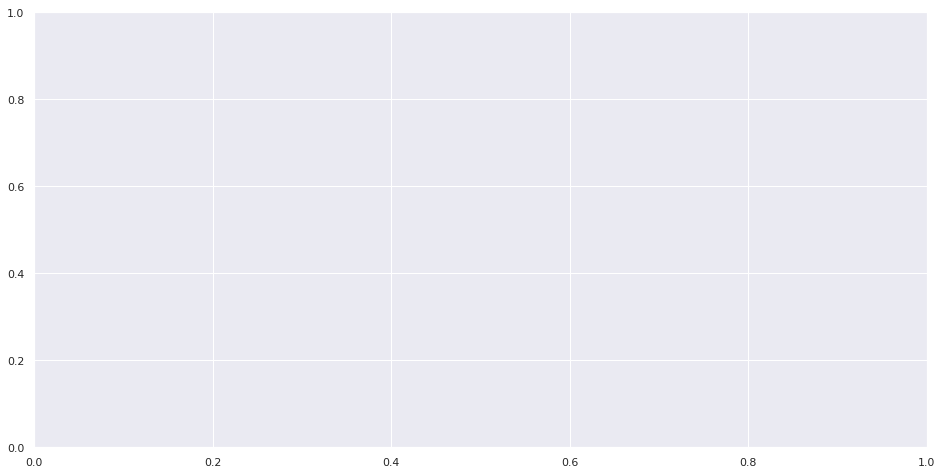

In [11]:
fields = ['FOOD_SERVICE',
          'GROCERY',
          'HEALTH_CARE',
          'K12_SCHOOLS',
          'LODGING',
          'OFFICE',
          'RESIDENTIAL',
          'STAND_ALONE_RETAIL',
          'ELECTRIC_CAR']

plot_types = ['bar', 'box']

def plot_me(field, plot_type):
    monthly_resampled = pd.to_numeric(consumption_master[field], downcast='float').resample('W').mean()
    plot = monthly_resampled.plot(kind=plot_type,subplots=False,sharex=False,sharey=False, title=field, figsize=(16, 8));
    plot.figure.savefig("./Images/{}plot_by_week_{}.png".format(plot_type, field))
    plot.cla()
    
    
for field in fields:
    plot_me(field, 'bar')
    

In [12]:
weekly_summary = pd.DataFrame()
#weekly_summary['speed'] = df.speed.resample('W').mean()
weekly_summary['GROCERY'] = pd.to_numeric(consumption_master[field], downcast='float').resample('W').mean()
#weekly_summary['distance'] = df.distance.resample('W').sum()
#weekly_summary['cumulative_distance'] = df.cumulative_distance.resample('W').last()
print(weekly_summary.head())

                GROCERY
Time                   
1900-01-07  6495.138672
1900-01-14  6590.987305
1900-01-21  6590.987305
1900-01-28  6590.987305
1900-02-04  6590.987305


In [33]:
#fields = ['Time',
#          'FOOD_SERVICE',
#          'GROCERY',
#          'HEALTH_CARE',
#          'K12_SCHOOLS',
#          'LODGING',
#          'OFFICE',
#          'RESIDENTIAL',
#          'STAND_ALONE_RETAIL']

fields = ['Time',
          'FOOD_SERVICE']

tmp = consumption_master[fields]

#tmp.set_index('Time', inplace=True)
tmp.truncate(before='1900-01-05', after='1900-01-05')

#tmp.reset_index(inplace=True)
#print(tmp.head())
#tmp.groupby(fields)
print(tmp.head(40))

                              FOOD_SERVICE
Time                                      
1900-01-01 01:00:00           0.0054160664
1900-01-01 02:00:00           0.0037892151
1900-01-01 03:00:00  0.0037971470000000003
1900-01-01 04:00:00  0.0038017171999999997
1900-01-01 05:00:00           0.0038614936
1900-01-01 06:00:00           0.0054753851
1900-01-01 07:00:00           0.0112654407
1900-01-01 08:00:00           0.0112457479
1900-01-01 09:00:00           0.0082334212
1900-01-01 10:00:00   0.008237147700000001
1900-01-01 11:00:00   0.010234684300000001
1900-01-01 12:00:00            0.010696906
1900-01-01 13:00:00            0.010321712
1900-01-01 14:00:00           0.0102417791
1900-01-01 15:00:00           0.0082429201
1900-01-01 16:00:00            0.008237276
1900-01-01 17:00:00           0.0082050167
1900-01-01 18:00:00   0.011218180900000001
1900-01-01 19:00:00   0.011218816000000001
1900-01-01 20:00:00           0.0112752084
1900-01-01 21:00:00   0.009270729200000001
1900-01-01 